# Tobacco 800 page stream segmentation experiments
> Image CNN

* img_training.ipynb
* train_text_cnn.ipynb
* text_activations.ipynb
* img_activations.ipynb
* sequence_clf_from_embs.ipynb
    * alterar a label

**Imports**

In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

**Seed**

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# tensorflow RNG
# tf.random.set_seed(seed)

## Load Data

In [3]:
path = Path("/mnt/nas/databases/Tobacco800/unziped/page_imgs/raw")

In [4]:
images = get_image_files(path)

In [129]:
df = pd.read_csv('/mnt/nas/databases/Tobacco800/unziped/train.csv', delimiter=';',  usecols=['binder','docid','class'])

In [130]:
df['split'] = 'train';print(df.shape); df.head()

(1031, 4)


,binder,docid,class,split
0,Tobacco800,aah97e00-page02_1,FirstPage,train
1,Tobacco800,aah97e00-page02_2,NextPage,train
2,Tobacco800,aam09c00,FirstPage,train
3,Tobacco800,aao54e00_1,FirstPage,train
4,Tobacco800,aao54e00_2,NextPage,train


In [131]:
df['split'][-200:] = 'valid'; df.iloc[-202:-198];

In [132]:
df

,binder,docid,class,split
0,Tobacco800,aah97e00-page02_1,FirstPage,train
1,Tobacco800,aah97e00-page02_2,NextPage,train
2,Tobacco800,aam09c00,FirstPage,train
3,Tobacco800,aao54e00_1,FirstPage,train
4,Tobacco800,aao54e00_2,NextPage,train
...,...,...,...,...
1026,Tobacco800,thl51a00-page02_2,NextPage,valid
1027,Tobacco800,tji44a00,FirstPage,valid
1028,Tobacco800,tjr72f00-page02_1,FirstPage,valid
1029,Tobacco800,tjr72f00-page02_2,NextPage,valid


In [133]:
df_test = pd.read_csv('/mnt/nas/databases/Tobacco800/unziped/test.csv', delimiter=';',  usecols=['binder','docid','class'])

In [134]:
df_test['split'] = 'test'

In [135]:
df = pd.concat([df, df_test], axis=0); df.reset_index(drop=True, inplace=True); df

,binder,docid,class,split
0,Tobacco800,aah97e00-page02_1,FirstPage,train
1,Tobacco800,aah97e00-page02_2,NextPage,train
2,Tobacco800,aam09c00,FirstPage,train
3,Tobacco800,aao54e00_1,FirstPage,train
4,Tobacco800,aao54e00_2,NextPage,train
...,...,...,...,...
1285,Tobacco800,zrz94a00-page02_2,NextPage,test
1286,Tobacco800,zss86d00,FirstPage,test
1287,Tobacco800,ztz52d00-page02_1,FirstPage,test
1288,Tobacco800,ztz52d00-page02_2,NextPage,test


In [136]:
def splitter(df):
    train = df[df['split']=='train'].index.tolist()
    valid = df[df['split']=='valid'].index.tolist()
    test = df[df['split']=='test'].index.tolist()
    return train,valid, test

In [137]:
def get_x(r): return path/f'{r["docid"]}.tif'
def get_y(r): return r['class']

In [138]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=splitter,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.9,
                                               do_flip=False, max_rotate=0,
                                               max_warp=0),
                               Normalize.from_stats(*imagenet_stats)])

In [140]:
#dblock.summary(df)

In [143]:
dls = dblock.dataloaders(df)

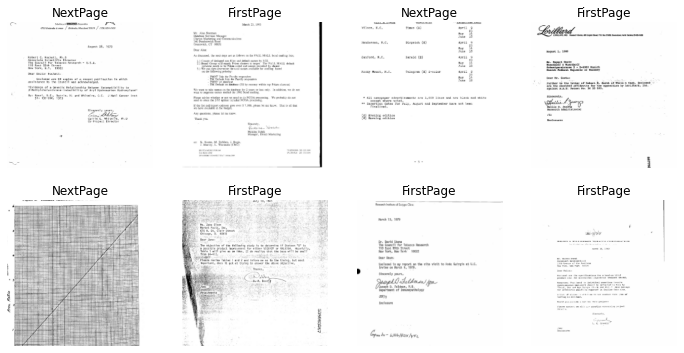

In [145]:
dls.show_batch(nrows=2, ncols=4)

In [31]:
dls_test = dblock_test.dataloaders(df_test)

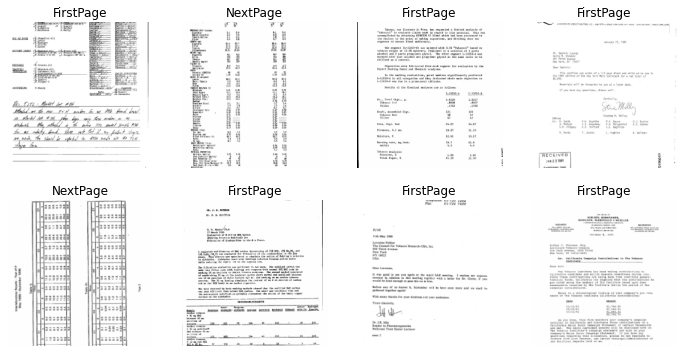

In [32]:
dls_test.show_batch(nrows=2, ncols=4)

## Train 

In [146]:
fscore = F1Score(average='weighted')

In [147]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, fscore], path='./')

In [148]:
learn.freeze()

In [ ]:
learn.summary()

SuggestedLRs(valley=0.0005754399462603033)

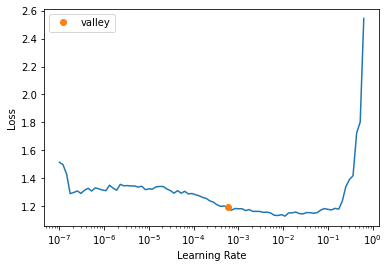

In [150]:
learn.lr_find()

In [151]:
learn.fit_one_cycle(1, 4e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.471607,1.567221,0.645000,0.643445,00:27


In [ ]:
learn.unfreeze()
learn.summary()

SuggestedLRs(valley=0.0010000000474974513)

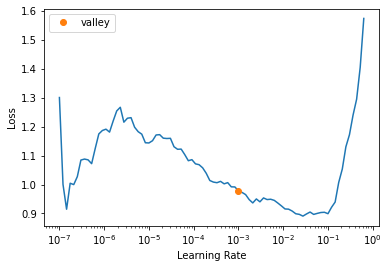

In [153]:
learn.lr_find()

In [154]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_image_no_weights_224'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.241834,1.568557,0.735000,0.730178,00:26
1,0.966129,2.011327,0.635000,0.600656,00:25
2,0.738321,0.670878,0.750000,0.749450,00:25
3,0.620904,0.618446,0.775000,0.775434,00:26


Better model found at epoch 0 with f1_score value: 0.7301775775931246.


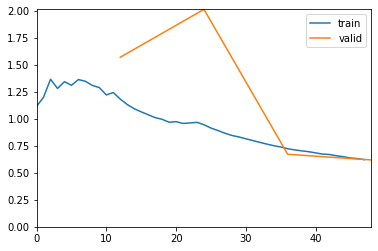

Better model found at epoch 2 with f1_score value: 0.7494497799119648.
Better model found at epoch 3 with f1_score value: 0.7754336562288805.


In [155]:
learn.fit_one_cycle(4, lr_max=slice(2e-4,2e-3))

In [156]:
learn.load("best_image_no_weights_224")

/mnt/home/fabraz/code/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [171]:
dls.loaders[2]

## Valid Set Performance

In [175]:
preds, targets = learn.get_preds()
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

              precision    recall  f1-score   support

   FirstPage     0.7255    0.8132    0.7668        91
    NextPage     0.8265    0.7431    0.7826       109

    accuracy                         0.7750       200
   macro avg     0.7760    0.7782    0.7747       200
weighted avg     0.7806    0.7750    0.7754       200



In [179]:
n_samples = len(dls.train_ds); n_samples

831

## Test Set Performance

In [174]:
preds, targets = learn.get_preds(ds_idx=2)
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

              precision    recall  f1-score   support

   FirstPage     0.8758    0.8933    0.8845       150
    NextPage     0.8491    0.8257    0.8372       109

    accuracy                         0.8649       259
   macro avg     0.8624    0.8595    0.8608       259
weighted avg     0.8646    0.8649    0.8646       259

